<a href="https://colab.research.google.com/github/Ruthra03/CBOW-algorithm-Single-context-/blob/main/cbow_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt

class CBOW:
    def __init__(self, vocab_size,word_index, W1, W2, reverse_word_index, embedding_dim, hidden_dim, learning_rate=0.001):
        np.random.seed(42)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.word_index = word_index
        self.reverse_word_index = reverse_word_index
        # Initialize weights randomly or load pre-trained weights
        #self.W1 = np.random.rand(vocab_size, hidden_dim)
        #self.W2 = np.random.rand(hidden_dim, vocab_size)
        self.W1 = W1
        self.W2 = W2



    def generate_one_hot(self, word_idx):
        one_hot = np.zeros(self.vocab_size)
        one_hot[int(word_idx)] = 1
        return one_hot

    def linear_activation(self, x):
        return x

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=0)

    def forward_pass(self, context):
        hidden_input = np.dot(self.W1.T, context)
        h = self.linear_activation(hidden_input)
        u = np.dot(self.W2.T, h)
        output_probs = self.softmax(u)
        return h, output_probs

    def backward_pass(self, context, target, h, output_probs):
        error_output = output_probs - target
        dW2 = np.outer(error_output, h)
        error_hidden = np.dot(self.W2, error_output)
        dW1 = np.outer(error_hidden, context)
        return dW1.T, dW2.T

    def update_weights(self, dW1, dW2):
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2

    def train(self, corpus, vocabulary=None, epochs = 1):
        losses = []
        for epoch in range(epochs):
            total_loss = 0.0
            for sentence in corpus:
                context_words = sentence.split()[:-1]
                target_word = sentence.split()[-1]

                context_vectors = [self.generate_one_hot(self.reverse_word_index[word]) for word in context_words]
                #print(context_vectors)
                context = np.mean(context_vectors, axis=0)
                target = self.generate_one_hot(self.reverse_word_index[target_word])
                h, output_probs = self.forward_pass(context)
                j_star = int(target.argmax())

                # Calculate cross-entropy loss
                loss = -np.log(output_probs[j_star])  # E = - ln(y)
                total_loss += loss

                dW1, dW2 = self.backward_pass(context, target, h, output_probs)
                self.update_weights(dW1, dW2)


            average_loss = total_loss / len(corpus)
            losses.append(average_loss)
        plt.plot(range(1, epochs + 1), losses, label='Average Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Average Loss')
        plt.title('Average Loss vs. Epochs')
        plt.xticks(range(0, epochs + 1, 1000))  # Set x-axis ticks to be divisible by 1000
        plt.legend()
        plt.show()

    def predict(self, input_word):
        if input_word in self.reverse_word_index:
            input_vector = self.generate_one_hot(self.reverse_word_index[input_word])
            _, output_probs = self.forward_pass(input_vector)
            predicted_word_index = np.argmax(output_probs)
            predicted_word = self.word_index[str(predicted_word_index)]

            # Format the output probabilities as specified
            #formatted_probs = [f"{word}: {prob:.6f}" for word, prob in zip(self.word_index.values(), output_probs)]

            return predicted_word, output_probs
        else:
            return "Word not in vocabulary", None

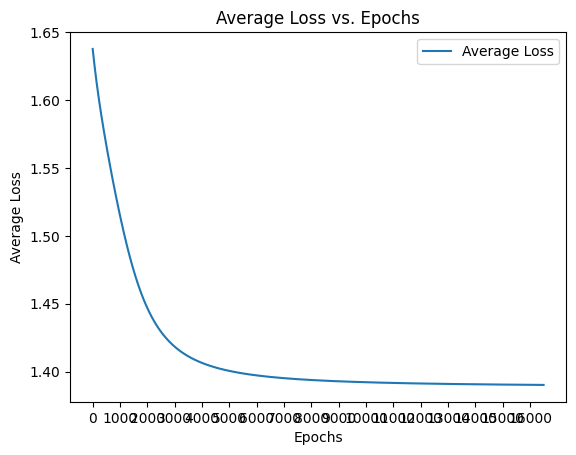

In [2]:
corpus = [
    "eat apple",
    "eat banana",
    "eat sapota",
    "eat carrot",
]
epochs = 16500
text_corpus = ' '.join(corpus)
W1 = np.array([[0.2,0.7,0.5],[0.3,0.2,0.5],[0.3,0.2,0.2],[0.5,0.4,0.2],[0.2,0.5,0.3]])
W2 = np.array([[0.3,0.4,0.3,0.1,0.2],[0.3,0.2,0.1,0.1,0.4],[0.4,0.2,0.4,0.3,0.5]])
# Tokenize the text into words
words = text_corpus.split()
# Count the occurrences of each word
word_counts = Counter(words)

# Sort words by their counts in descending order
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
#print(sorted_words)

# Create a dictionary with unique words and assign an index
word_index = {'0': sorted_words[0]}  # Assign '0' to the most repeated word
word_index.update({str(i + 1): word for i, word in enumerate(sorted_words[1:])})
reverse_word_index = {value: key for key, value in word_index.items()}

vocab_size = len(word_counts)
embedding_dim = vocab_size
hidden_dim = 3

cbow = CBOW(vocab_size, word_index, W1, W2, reverse_word_index, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

cbow.train(corpus, sorted_words, epochs)

In [3]:
context = "eat"
predicted_word, probs = cbow.predict(context)
print(f"Predicted word after '{context}': {predicted_word}")
print("Probabilities:")
for i in range(vocab_size):
  print(f"P({word_index[str(i)]}|{context})= {probs[i]}")

Predicted word after 'eat': carrot
Probabilities:
P(eat|eat)= 0.002098894793351186
P(apple|eat)= 0.2490426585954147
P(banana|eat)= 0.24933212376290195
P(sapota|eat)= 0.2496214290326232
P(carrot|eat)= 0.24990489381570902
